In [44]:
#imports
import os
from six.moves import urllib
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from statsmodels import robust
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve

In [45]:
DOWNLOAD_ROOT = "http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening"
CREDIT_DATA_URL = DOWNLOAD_ROOT + "/crx.data"
CREDIT_DATA_PATH = "datasets/credit-screening"

In [46]:
# fetch data from its origin
def fetch_credit_crad_data(credit_data_url=CREDIT_DATA_URL, credit_path=CREDIT_DATA_PATH):
    if not os.path.isdir(credit_path):
        os.makedirs(credit_path)
    credit_data_path = os.path.join(credit_path, "crx.data")
    urllib.request.urlretrieve(credit_data_url, credit_data_path)

fetch_credit_crad_data()

In [47]:
def load_credit_card_data(credit_data_path=CREDIT_DATA_PATH):
    csv_path=os.path.join(credit_data_path, "crx.data")
    pd.set_option('display.max_columns', None)
    col_names = ["Gender","Age","Debt","Married","BankCustomer","EducationLevel","Ethnicity",
                 "YearsEmployed","PriorDefault","Employed","CreditScore", "DriversLicense", "Citizen", 
                 "ZipCode", "Income" , "ApprovalStatus"]
    return pd.read_csv(csv_path, header=None, names=col_names)

data = load_credit_card_data()
dataset = data.copy()
dataset.head().T

,0,1,2,3,4
Gender,b,a,a,b,b
Age,30.83,58.67,24.50,27.83,20.17
Debt,0,4.46,0.5,1.54,5.625
Married,u,u,u,u,u
BankCustomer,g,g,g,g,g
EducationLevel,w,q,q,w,w
Ethnicity,v,h,h,v,v
YearsEmployed,1.25,3.04,1.5,3.75,1.71
PriorDefault,t,t,t,t,t
Employed,t,t,f,t,f


In [48]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
Gender            690 non-null object
Age               690 non-null object
Debt              690 non-null float64
Married           690 non-null object
BankCustomer      690 non-null object
EducationLevel    690 non-null object
Ethnicity         690 non-null object
YearsEmployed     690 non-null float64
PriorDefault      690 non-null object
Employed          690 non-null object
CreditScore       690 non-null int64
DriversLicense    690 non-null object
Citizen           690 non-null object
ZipCode           690 non-null object
Income            690 non-null int64
ApprovalStatus    690 non-null object
dtypes: float64(2), int64(2), object(12)
memory usage: 86.3+ KB


In [49]:
dataset['CreditScore'].value_counts().sort_values(ascending=True)

67      1
19      1
13      1
40      1
23      1
20      2
17      2
16      3
15      4
10      8
12      8
14      8
8      10
9      10
4      15
7      16
5      18
11     19
6      23
3      28
2      45
1      71
0     395
Name: CreditScore, dtype: int64

In [50]:
#replace some values so it makes sense
dataset = dataset.replace("?", np.nan).replace('+', 1).replace('-', 0)

#drop all row which have at least one null value
dataset.dropna(inplace=True)
dataset.isna().sum()

Gender            0
Age               0
Debt              0
Married           0
BankCustomer      0
EducationLevel    0
Ethnicity         0
YearsEmployed     0
PriorDefault      0
Employed          0
CreditScore       0
DriversLicense    0
Citizen           0
ZipCode           0
Income            0
ApprovalStatus    0
dtype: int64

In [51]:
dataset['Age'] = dataset['Age'].astype('float')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653 entries, 0 to 689
Data columns (total 16 columns):
Gender            653 non-null object
Age               653 non-null float64
Debt              653 non-null float64
Married           653 non-null object
BankCustomer      653 non-null object
EducationLevel    653 non-null object
Ethnicity         653 non-null object
YearsEmployed     653 non-null float64
PriorDefault      653 non-null object
Employed          653 non-null object
CreditScore       653 non-null int64
DriversLicense    653 non-null object
Citizen           653 non-null object
ZipCode           653 non-null object
Income            653 non-null int64
ApprovalStatus    653 non-null int64
dtypes: float64(3), int64(3), object(10)
memory usage: 86.7+ KB


In [52]:
dataset['ApprovalStatus'].value_counts()

0    357
1    296
Name: ApprovalStatus, dtype: int64

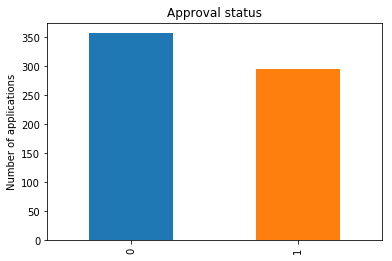

In [53]:
CountStatus = pd.value_counts(dataset['ApprovalStatus'].values, sort=False)
plt.ylabel('Number of applications')
plt.title('Approval status')
CountStatus.plot.bar()

In [54]:
# convert dataset_dropNa cat attributes to numeric
le = LabelEncoder()

for col in dataset:
    if dataset[col].dtypes == 'object':
        dataset[col]=le.fit_transform(dataset[col])
dataset.dtypes

Gender              int32
Age               float64
Debt              float64
Married             int32
BankCustomer        int32
EducationLevel      int32
Ethnicity           int32
YearsEmployed     float64
PriorDefault        int32
Employed            int32
CreditScore         int64
DriversLicense      int32
Citizen             int32
ZipCode             int32
Income              int64
ApprovalStatus      int64
dtype: object

In [55]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653 entries, 0 to 689
Data columns (total 16 columns):
Gender            653 non-null int32
Age               653 non-null float64
Debt              653 non-null float64
Married           653 non-null int32
BankCustomer      653 non-null int32
EducationLevel    653 non-null int32
Ethnicity         653 non-null int32
YearsEmployed     653 non-null float64
PriorDefault      653 non-null int32
Employed          653 non-null int32
CreditScore       653 non-null int64
DriversLicense    653 non-null int32
Citizen           653 non-null int32
ZipCode           653 non-null int32
Income            653 non-null int64
ApprovalStatus    653 non-null int64
dtypes: float64(3), int32(10), int64(3)
memory usage: 61.2 KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D43607C4E0>,
      dtype=object)

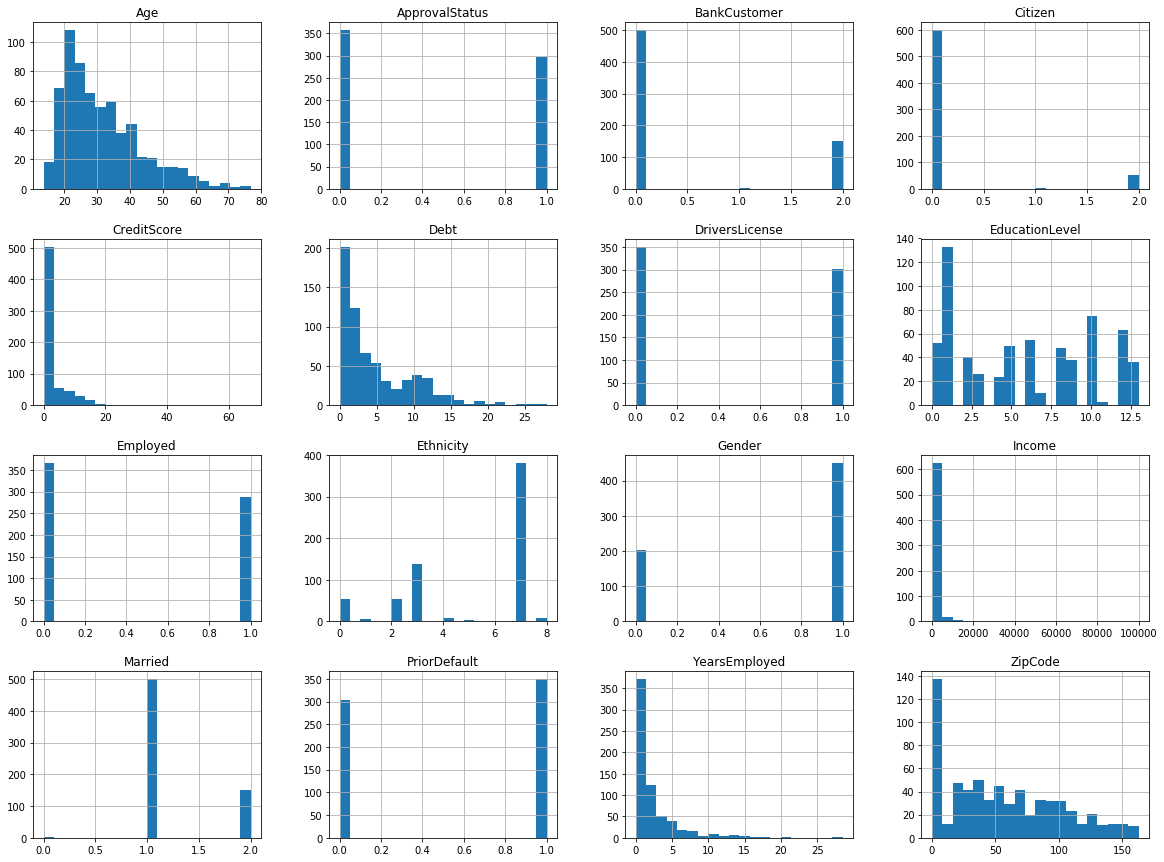

In [56]:
dataset.hist(bins=20, figsize=(20,15))

In [57]:
corr = dataset.corr()
corr

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,ApprovalStatus
Gender,1.000000,0.042177,-0.034906,0.066742,0.063122,-0.011568,0.057212,0.084899,-0.023251,-0.065192,-0.016683,0.052315,0.081948,0.109199,0.013099,-0.019817
Age,0.042177,1.000000,0.217681,-0.091395,-0.105122,0.023282,-0.189454,0.417647,0.218637,0.103633,0.198153,0.058133,-0.021586,-0.090538,0.029078,0.180252
Debt,-0.034906,0.217681,1.000000,-0.102243,-0.089745,0.009221,-0.030666,0.300600,0.236751,0.166092,0.269834,-0.006083,-0.105181,-0.266549,0.119754,0.207086
Married,0.066742,-0.091395,-0.102243,1.000000,0.981080,-0.045024,-0.021015,-0.089650,-0.116015,-0.158118,-0.104061,-0.009850,-0.037934,-0.001085,-0.118505,-0.179700
BankCustomer,0.063122,-0.105122,-0.089745,0.981080,1.000000,-0.051335,-0.026003,-0.081862,-0.129090,-0.169691,-0.110822,0.001747,-0.011931,0.013922,-0.018528,-0.169976
EducationLevel,-0.011568,0.023282,0.009221,-0.045024,-0.051335,1.000000,-0.000935,0.032704,0.105197,0.112155,-0.002706,0.069720,0.017234,0.107930,-0.006700,0.123314
Ethnicity,0.057212,-0.189454,-0.030666,-0.021015,-0.026003,-0.000935,1.000000,-0.094978,-0.034977,-0.001452,-0.037329,-0.004235,0.042494,-0.019605,-0.022527,-0.011023
YearsEmployed,0.084899,0.417647,0.300600,-0.089650,-0.081862,0.032704,-0.094978,1.000000,0.336148,0.228035,0.327325,0.139317,-0.001762,-0.093188,0.052159,0.332728
PriorDefault,-0.023251,0.218637,0.236751,-0.116015,-0.129090,0.105197,-0.034977,0.336148,1.000000,0.430586,0.378264,0.089864,-0.110474,-0.064796,0.084427,0.738829
Employed,-0.065192,0.103633,0.166092,-0.158118,-0.169691,0.112155,-0.001452,0.228035,0.430586,1.000000,0.569176,0.020223,-0.233452,-0.070939,0.068189,0.451866


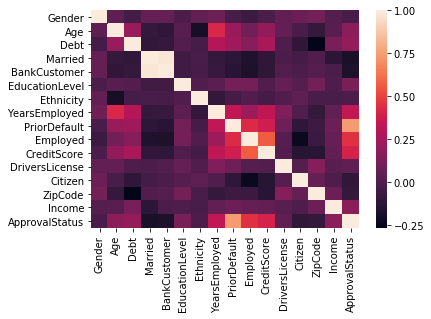

In [58]:
def make_corr_heatmap(data, corr):
    sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

make_corr_heatmap(dataset, corr)

In [59]:
corr['ApprovalStatus'].sort_values(ascending=False)

ApprovalStatus    1.000000
PriorDefault      0.738829
Employed          0.451866
CreditScore       0.406052
YearsEmployed     0.332728
Debt              0.207086
Age               0.180252
Income            0.172766
EducationLevel    0.123314
DriversLicense    0.050011
Ethnicity        -0.011023
Gender           -0.019817
ZipCode          -0.092483
Citizen          -0.100785
BankCustomer     -0.169976
Married          -0.179700
Name: ApprovalStatus, dtype: float64

In [60]:
dataset_dropColumns = dataset.drop(columns=['Ethnicity', 'Gender', 'ZipCode'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D4395F8E10>,
      dtype=object)

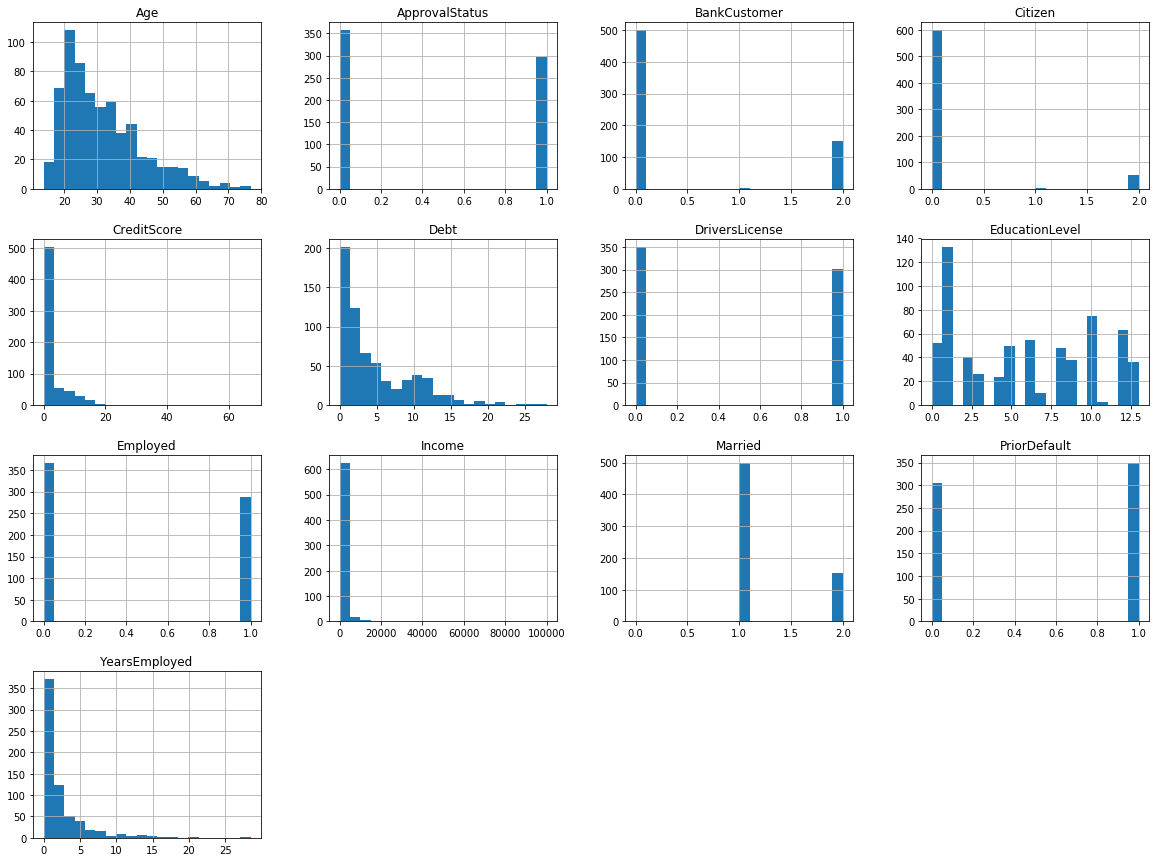

In [61]:
dataset_dropColumns.hist(bins=20, figsize=(20, 15))

In [62]:
dataset_dropColumns['Citizen'].value_counts()


0    598
2     53
1      2
Name: Citizen, dtype: int64

In [63]:
#dataset_Citizen_3_values = dataset_dropColumns[dataset_dropColumns['Citizen'] == 1]
#dataset_Citizen_3_values

In [64]:
#dataset_Married_3_values = dataset_dropColumns[dataset_dropColumns['Married'] == 0]
#dataset_Married_3_values.head()

In [65]:
#dataset_dropColumns = dataset_dropColumns[dataset_dropColumns['Married'] != 0]
#dataset_dropColumns = dataset_dropColumns[dataset_dropColumns['Citizen'] != 1]
dataset_dropColumns['Married'].value_counts()

1    499
2    152
0      2
Name: Married, dtype: int64

In [66]:
dataset_dropColumns[dataset_dropColumns['CreditScore']<8]['CreditScore'].value_counts().sum()

574

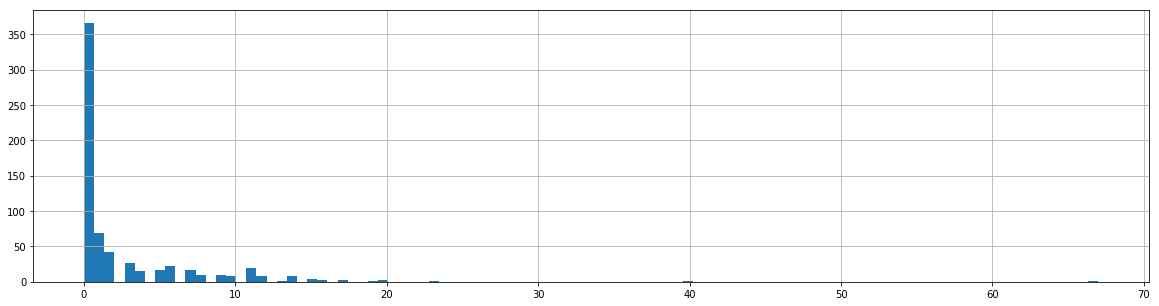

In [67]:
dataset_dropColumns['CreditScore'].hist(bins=100, figsize=(20, 5))

In [68]:
dataset_dropColumns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653 entries, 0 to 689
Data columns (total 13 columns):
Age               653 non-null float64
Debt              653 non-null float64
Married           653 non-null int32
BankCustomer      653 non-null int32
EducationLevel    653 non-null int32
YearsEmployed     653 non-null float64
PriorDefault      653 non-null int32
Employed          653 non-null int32
CreditScore       653 non-null int64
DriversLicense    653 non-null int32
Citizen           653 non-null int32
Income            653 non-null int64
ApprovalStatus    653 non-null int64
dtypes: float64(3), int32(7), int64(3)
memory usage: 53.6 KB


In [69]:
# one hot encoding 'Citizen', 'Married', 'BankCustomer'

preprocess = make_column_transformer((OneHotEncoder(categories='auto'), ['Citizen', 'Married', 'BankCustomer']))

In [27]:
dataset_dropColumns_nominal = preprocess.fit_transform(dataset_dropColumns)

In [28]:
dataset_dropColumns_nominal
data_nominal_1hot = pd.DataFrame(data=dataset_dropColumns_nominal[0:, 0:])

In [29]:
dataset_dropColumns=dataset_dropColumns.drop(columns=['Citizen', 'Married', 'BankCustomer'])

In [39]:
dataset_dropColumns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653 entries, 0 to 689
Data columns (total 10 columns):
Age               653 non-null float64
Debt              653 non-null float64
EducationLevel    653 non-null int32
YearsEmployed     653 non-null float64
PriorDefault      653 non-null int32
Employed          653 non-null int32
CreditScore       653 non-null int64
DriversLicense    653 non-null int32
Income            653 non-null int64
ApprovalStatus    653 non-null int64
dtypes: float64(3), int32(4), int64(3)
memory usage: 45.9 KB


In [40]:
# dataset_1hot is a np array that has all data in it after one hot encoding
dataset_1hot = np.concatenate((dataset_dropColumns_nominal,dataset_dropColumns.iloc[0:, 0:]),axis=1)

In [32]:
dataset_1hot

array([[  1.,   0.,   0., ...,   0.,   0.,   1.],
       [  1.,   0.,   0., ...,   0., 560.,   1.],
       [  1.,   0.,   0., ...,   0., 824.,   1.],
       ...,
       [  1.,   0.,   0., ...,   1.,   1.,   0.],
       [  1.,   0.,   0., ...,   0., 750.,   0.],
       [  1.,   0.,   0., ...,   1.,   0.,   0.]])

In [70]:
labels = ['Citizen_1', 'Citizen_2', 'Citizen_3', 'Married_1', 'Married_2', 'Married_3', 'BankCustomer_1', 'BankCustomer_2', 'BankCustomer_3','Age','Debt', 'EducationLevel', 
          'YearsEmployed', 'PriorDefault', 'Employed', 'CreditScore', 'DriversLicense', 'Income', 'ApprovalStatus']

In [71]:
df_1hot = pd.DataFrame(data=dataset_1hot[0:, 0:], columns=labels)
df_1hot["ApprovalStatus"].value_counts()

0.0    357
1.0    296
Name: ApprovalStatus, dtype: int64

In [72]:
df_1hot['ApprovalStatus'] = df_1hot['ApprovalStatus'].astype(int)

In [85]:
df_1hot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653 entries, 0 to 652
Data columns (total 19 columns):
Citizen_1         653 non-null float64
Citizen_2         653 non-null float64
Citizen_3         653 non-null float64
Married_1         653 non-null float64
Married_2         653 non-null float64
Married_3         653 non-null float64
BankCustomer_1    653 non-null float64
BankCustomer_2    653 non-null float64
BankCustomer_3    653 non-null float64
Age               653 non-null float64
Debt              653 non-null float64
EducationLevel    653 non-null float64
YearsEmployed     653 non-null float64
PriorDefault      653 non-null float64
Employed          653 non-null float64
CreditScore       653 non-null float64
DriversLicense    653 non-null float64
Income            653 non-null float64
ApprovalStatus    653 non-null int32
dtypes: float64(18), int32(1)
memory usage: 94.5 KB


In [87]:
df_values = df_1hot.values
X, y = df_values[:, 0:18], df_values[:, 18]

In [88]:
import collections
collections.Counter(y)

Counter({1.0: 296, 0.0: 357})

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [100]:

scaler=StandardScaler()

#scaler = MinMaxScaler()
#scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.fit_transform(X_test)

In [101]:
def display_scores(scores, classifier):
    print(classifier + " scores are: ", scores)
    print(classifier + " mean is: ", scores.mean())
    print(classifier + " std is: ", scores.std())

In [102]:
def display_scores_confuionMarix(classifier, y_train, y_pred):
    print(classifier + " precision score: ", precision_score(y_train, y_pred))
    print(classifier + " recall score: ", recall_score(y_train, y_pred))
    print(classifier + " F1 score: ", f1_score(y_train, y_pred))


In [103]:
def print_confusion_matrix(tn, fp, fn, tp):
    print("TN: ", tn)
    print("FP: ", fp)
    print("FN: ", fn)
    print("TP: ", tp)


In [104]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):    
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")    
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")    
    plt.xlabel("Threshold")    
    plt.legend(loc="upper left")    
    plt.ylim([0, 1])


In [105]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

Logistic Regression scores are:  [0.88043478 0.92391304 0.89010989 0.81318681 0.85714286]
Logistic Regression mean is:  0.8729574773053033
Logistic Regression std is:  0.036794618040342696
Logistic Regression precision score:  0.8304347826086956
Logistic Regression recall score:  0.9095238095238095
Logistic Regression F1 score:  0.8681818181818182
TN:  208
FP:  39
FN:  19
TP:  191
roc_value:  0.9280019436345966


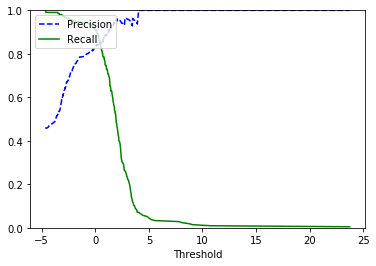

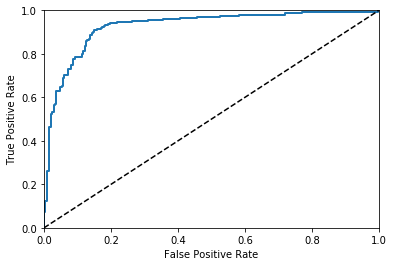

In [106]:
#####Logistic regression
logReg = LogisticRegression(solver='liblinear')
#logReg.fit(rescaledX_train, y_train)

classifier = "Logistic Regression"

#use cross-validation get scores and predictions
y_train_pred = cross_val_predict(logReg, rescaledX_train, y_train, cv=5)
logReg_scores = cross_val_score(logReg, rescaledX_train, y_train, cv=5)

#print metrics and scores
display_scores(logReg_scores, classifier)
display_scores_confuionMarix(classifier, y_train, y_train_pred)


# Print the confusion matrix of the logreg model
confusionMatrix = confusion_matrix(y_train, y_train_pred)
tn, fp, fn, tp = confusionMatrix.ravel()
print_confusion_matrix(tn, fp, fn, tp)

#ROC
roc_value = cross_val_score(logReg, X_train, y_train, cv=5, scoring="roc_auc").mean()
print("roc_value: ", roc_value.mean())

##making ROC_CURVE plot
y_scores = cross_val_predict(logReg, rescaledX_train, y_train, cv=5, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

fpr, tpr, thresholds = roc_curve(y_train, y_scores)
plot_roc_curve(fpr, tpr)
plt.show()


Random Forest Regression scores are:  [0.80434783 0.84782609 0.86813187 0.79120879 0.84615385]
Random Forest Regression mean is:  0.8315336837075966
Random Forest Regression std is:  0.028926757392916447
Random Forest Regression precision score:  0.8308457711442786
Random Forest Regression recall score:  0.7952380952380952
Random Forest Regression F1 score:  0.8126520681265207
TN:  213
FP:  34
FN:  43
TP:  167
roc_value:  0.9100320699708455


D:\Anaconda3\lib\site-packages\matplotlib\legend.py:497: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


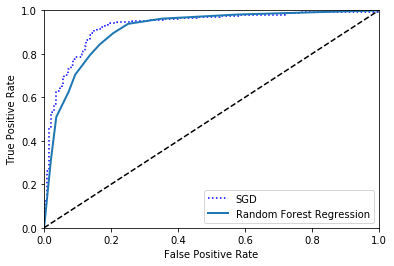

In [109]:
#Random Forest
randomForest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=0)
#randomForest.fit(X_train, y_train)
classifier = "Random Forest Regression"

#use cross-validation get scores and predictions
randomForest_scores = cross_val_score(randomForest, X_train, y_train, cv=5)
y_train_pred = cross_val_predict(randomForest, X_train, y_train, cv=5)

#print metrics
display_scores(randomForest_scores, classifier)
display_scores_confuionMarix(classifier, y_train, y_train_pred)

# Print the confusion matrix of the random forest model
confusionMatrix = confusion_matrix(y_train, y_train_pred)
tn, fp, fn, tp = confusionMatrix.ravel()
print_confusion_matrix(tn, fp, fn, tp)

##making ROC_CURVE plot
y_probs = cross_val_predict(randomForest, rescaledX_train, y_train, cv=5, method="predict_proba")

#roc_value = roc_auc_score(y_train_pred, y_probs)

roc_value = cross_val_score(randomForest, X_train, y_train, cv=5, scoring="roc_auc")
print("roc_value: ", roc_value.mean())
y_score_forest = y_probs[:, 1]

fp_forest, tp_forest, thresholds_forest = roc_curve(y_train, y_score_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fp_forest, tp_forest, classifier)
plt.legend(loc="bottom right")
plt.show()

In [110]:
#Naive bayes
naiveBayes = GaussianNB()
#naiveBayes.fit(rescaledX_train, y_train)

classifier = "Naive Bayes Regression"

#use cross validation grt scores and predictions
y_train_pred = cross_val_predict(naiveBayes, X=rescaledX_train, y=y_train, cv=5)
naiveBayes_scores = cross_val_score(estimator=naiveBayes, X=rescaledX_train, y=y_train, cv=5)

#print metrics
display_scores(naiveBayes_scores, classifier)
display_scores_confuionMarix(classifier, y_train, y_train_pred)

# Print the confusion matrix of the random forest model
confusionMatrix = confusion_matrix(y_train, y_train_pred)
tn, fp, fn, tp = confusionMatrix.ravel()
print_confusion_matrix(tn, fp, fn, tp)

#ROC
roc_value = cross_val_score(naiveBayes, X_train, y_train, cv=5, scoring="roc_auc")
print("roc_value: ", roc_value.mean())



Naive Bayes Regression scores are:  [0.63043478 0.61956522 0.6043956  0.64835165 0.85714286]
Naive Bayes Regression mean is:  0.671978021978022
Naive Bayes Regression std is:  0.09368516179265575
Naive Bayes Regression precision score:  0.9166666666666666
Naive Bayes Regression recall score:  0.3142857142857143
Naive Bayes Regression F1 score:  0.4680851063829787
TN:  241
FP:  6
FN:  144
TP:  66
roc_value:  0.8914207968901847


In [112]:
param_grid = {
    'max_depth': np.linspace(1, 32, 32, endpoint=True),
    'max_features': list(range(1,rescaledX_train.shape[1])),
    'min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint=True),
    'min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
    'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200]
}
grid_search = GridSearchCV(estimator = randomForest, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(rescaledX_train, y_train)
est_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

#rgs = RandomizedSearchCV(estimator=randomForest, param_distributions  = param_grid, n_iter = 5000, cv = 10, n_jobs = -1, verbose = 2)
#rgs.fit(rescaledX_train, y_train)

#rgs.best_params_

Fitting 5 folds for each of 244800 candidates, totalling 1224000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 922 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 2067 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 3482 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 4713 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5603 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 6657 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 7871 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 9249 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 10787 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 12489 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 14351 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 16377 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 18563 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 20913 tasks

KeyboardInterrupt: 

In [ ]:
rfc_best_model = RandomForestClassifier(max_depth=20.0,max_features=3,min_samples_leaf=0.1,
                                        min_samples_split= 0.3,
                                        n_estimators=10,random_state=42)